In [1322]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import regularizers


In [1323]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the training data for validation
)



# Data preprocessing for testing data (no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Directory paths
training_data_dir = '/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/train'
testing_data_dir = '/Users/gabeprice/Desktop/Blackwell Research 2024/Alzheimers Research/Alzheimer_s Photos/test'

# Load the training data
train_data = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(208, 176),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Load the validation data
val_data = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(208, 176),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Load the testing data without augmentation
test_data = test_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(208, 176),
    batch_size=16,
    class_mode='categorical'
)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [1324]:
model = Sequential()

In [1325]:
# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(208, 176, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.1))

# Global Average Pooling and Fully Connected Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

# Load weights into the model
model.load_weights('model_checkpoint.weights.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [1326]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
# Define the optimizer with a fixed learning rate
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [1327]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)



In [1328]:
# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr * 0.1  # Reduce the learning rate by a factor of 0.1 every 15 epochs
        print(f"Learning rate reduced to {lr}")
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)



In [1329]:
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs')

In [1330]:
# Define ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [1331]:
from sklearn.utils import class_weight
import numpy as np

# Assuming `train_data.classes` is a numpy array or list with your class labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_data.classes), 
    y=train_data.classes
)

# Convert to dictionary format required by Keras
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [1332]:
# Load previous weights if they exist
try:
    model.load_weights(checkpoint_filepath)
    print("Loaded weights from checkpoint")
except:
    print("No checkpoint found, training from scratch")

Loaded weights from checkpoint


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [1333]:
# Train the model with class weights
hist = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    class_weight=class_weights_dict,  # Pass the class weights dictionary here
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback, lr_scheduler]
)


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


257/257 ━━━━━━━━━━━━━━━━━━━━ 126s 472ms/step - accuracy: 0.9948 - loss: 0.0519 - val_accuracy: 0.6950 - val_loss: 1.1102 - learning_rate: 1.0000e-04
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 119s 463ms/step - accuracy: 0.9953 - loss: 0.0487 - val_accuracy: 0.5650 - val_loss: 2.7270 - learning_rate: 1.0000e-04
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 120s 464ms/step - accuracy: 0.9851 - loss: 0.0670 - val_accuracy: 0.7195 - val_loss: 0.9813 - learning_rate: 1.0000e-04
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 120s 467ms/step - accuracy: 0.9986 - loss: 0.0443 - val_accuracy: 0.5836 - val_loss: 1.9442 - learning_rate: 1.0000e-04
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 121s 471ms/step - accuracy: 0.9971 - loss: 0.0516 - val_accuracy: 0.7136 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 117s 455ms/step - accuracy: 0.9980 - loss: 0.0450 - val_accuracy: 0.3509 - val_loss: 3.7452 - learning_rate: 1.0000e-04
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 114s 

In [1334]:
if hist.history['val_loss'][-1] == min(hist.history['val_loss']):
    print("Training completed successfully.")
else:
    print("Early stopping was triggered.")


Early stopping was triggered.


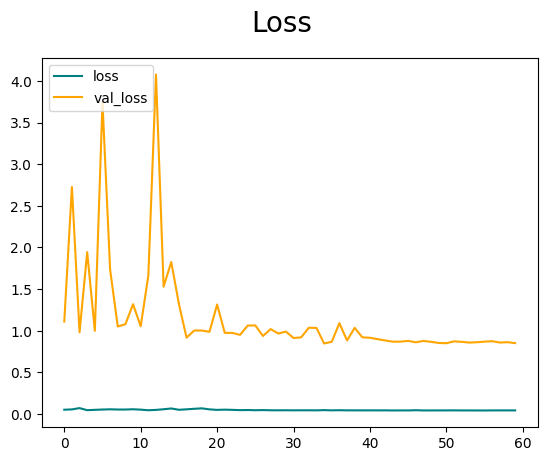

In [1335]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()



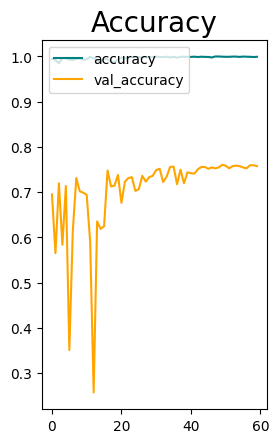

In [1336]:
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()



In [1337]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Ensure you import necessary modules
import numpy as np
from tqdm import tqdm  # For a progress bar


In [1338]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()


In [1339]:
# Number of steps in the validation generator
num_batches = len(val_data)

In [1340]:
# Iterate over the validation data generator with a counter
for i, batch in enumerate(val_data):
    if i >= num_batches:
        break
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/s

In [1341]:
# Get the results
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()

print(f'Precision: {precision_result}')
print(f'Recall: {recall_result}')
print(f'Accuracy: {accuracy_result}')

Precision: 0.7630000114440918
Recall: 0.7458455562591553
Accuracy: 0.7556207180023193


In [1342]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# Predict the classes of the test data
y_pred = model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)

# Get true labels
y_true = test_data.classes

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

class_labels = list(test_data.class_indices.keys())  # Get class labels

print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred_classes))


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.7423 - loss: 0.9549
Test Accuracy: 0.7310398817062378
Test Loss: 1.0156147480010986
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.14      0.18      0.16       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.49      0.44      0.46       640
VeryMildDemented       0.34      0.35      0.35       448

        accuracy                           0.37      1279
       macro avg       0.24      0.24      0.24      1279
    weighted avg       0.39      0.37      0.38      1279

Confusion Matrix:
[[ 33   3  78  65]
 [  1   0   8   3]
 [120   9 280 231]
 [ 84   3 204 157]]
